# BIOINF 305. Assignment - week 37.
## Assem Maratova

**Simulate the dynamics of a feedforward loop (X->Y, Y->Z, X->Z).**

Make the following assumptions:

- The cell expresses numerous copies of protein X. Whenever signal Sx appears or disappears, step-like activation or deactivation of X is triggered (no delay between Sx switching on/off and X becoming activated/deactivated).
- The signal Sy for activation of Y is present throughout the simulation such that all copies of protein Y that are produced immediately become active, Y*=Y.
- The production rate of Y is modelled using an activating or repressing Hill function f(X).
- The production rate of Z is modelled using a product of activating or repressing Hill functions f(X)*g(Y) (AND logic).

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# setting some parameters for plots
plt.style.use('seaborn')
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title 
plt.rcParams['figure.figsize'] = 10 , 6 # default figure size

In [3]:
def Hill_activator(X,K,n): 
    Xn = np.power(X,n)
    Kn = np.power(K,n)
    f_X = Xn/((Kn)+Xn)
    return f_X

def Hill_repressor(X,K,n): 
    f_X = 1.0 - Hill_activator(X,K,n)
    return f_X

In [4]:
def Hill_y_regulator(Y,t,X,B,a,K,n):
    return B*Hill_activator(X,K,n)-(a*Y)

def Hill_z_regulator(Z,t,X,Y,B,a,Kxy,Kyz,n): 
    return B*Hill_activator(X,Kxy,n)*Hill_activator(Y,Kyz,n)-(a*Z)

In [5]:
# data for simulation
Bx, ax = 1, 1
By, ay = 1, 1
Bz, az = 1, 1
Kxy, Kyz = 0.5, 0.75
n = 20
D = [5,15,25,28]
time = np.linspace(0,35,100)
signal = 1*((time>D[0])&(time<D[1])) | ((time>D[2])&(time<D[3]))

In [6]:
def rate_X_Y(u,t,ax,ay,az,Bx,By,Bz,Kxy,Kyz,n,D):
    x,y,z = u
    dxdt = step_x(x,t,Bx,ax,D)
    if (t<D[0] and t>D[1]) or (t<D[2] and t>D[3]):
        x = 0
    dydt = Hill_y_regulator(y,t,x,By,ay,Kxy,n)
    dzdt = Hill_z_regulator(z,t,x,y,Bz,az,Kxy,Kyz,n)
    return [dxdt,dydt,dzdt]

def step_x(X,t,B,a,D):
    if (t>D[0] and t<D[1]) or (t>D[2] and t<D[3]):
        dxdt = B - (a*X)
    else:
        dxdt = -(a*X)
    return dxdt

In [7]:
U1 = odeint(rate_X_Y,[0,0,0],time,
            args=(ax,ay,az,Bx,By,Bz,Kxy,Kyz,n,D))

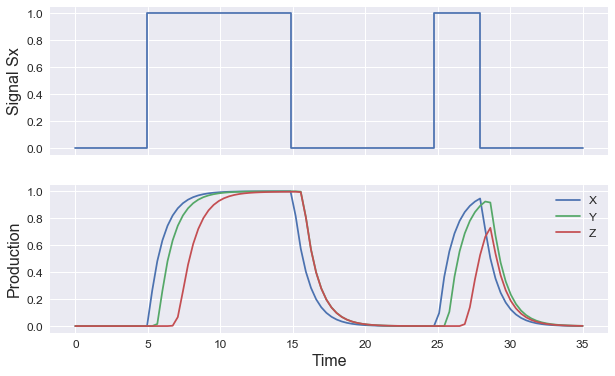

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.step(time,signal)
ax1.set_ylabel('Signal Sx')
ax2.plot(time,U1[:,0],label='X')
ax2.plot(time,U1[:,1],label='Y')
ax2.plot(time,U1[:,2],label='Z')
ax2.set_xlabel('Time')
ax2.set_ylabel('Production')
ax2.legend()
plt.show()

**Coherent FFL where X and Y are both activators**

- Calculate the temporal profiles of Y and Z following an ON step of Sx (Sx=0 for t<=0 and Sx=1 for t>0).
- Calculate the temporal profiles of Y and Z following an OFF step of Sx (Sx=1 for t<=0 and Sx=0 for t>0).
- Calculate the temporal profiles of Y and Z for pulses of Sx (Sx=0 except for a pulse of duration D). Compare the profiles for pulses of various lengths.

**Incoherent FFL where X is an activator and Y a repressor**

- Calculate the temporal profiles of Y and Z following an ON step of Sx (Sx=0 for t<=0 and Sx=1 for t>0).
- Calculate the temporal profiles of Y and Z following an OFF step of Sx (Sx=1 for t<=0 and Sx=0 for t>0).

In [9]:
def d_x(X,t,b,a,D):
    if t<D:
        dxdt = b - (a*X)
    else:
        dxdt = -(a*X)
    return dxdt

def d_y(Y,t,X,b,a,D):
    if t<D:
        dydt = b - (a*Y)
    else:
        dydt = -(a*Y)
    return dydt

def d_z(Z,t,X,Y,b,b_,a,T_,D):
    if t<T_:
        dzdt = b - (a*Z)
    elif (t>T_) and (t<D):
        dzdt = b_ - (a*Z)
    else:
        dzdt = -(a*Z)
    return dzdt

In [10]:
# additional data for simulation
Bz_ = 0.5 
Xst, Yst =  Bx/ax, By/ay
Zm, Zst= Bz/az, Bz_/az
T_ = (1/ay)*np.log(1/(1-(Kyz/Yst)))
D = 15
signal = 1*(time>0)&(time<D)

In [14]:
def rate_X_Y_2(u,t,ax,ay,az,Bx,By,Bz,Bz_,T_,D):
    x,y,z = u
    dxdt = d_x(x,t,Bx,ax,D)
    dydt = d_y(y,t,x,By,ay,D)
    dzdt = d_z(z,t,x,y,Bz,Bz_,az,T_,D)
    return [dxdt,dydt,dzdt]

In [15]:
U2 = odeint(rate_X_Y_2,[0,0,0],time,args=(ax,ay,az,Bx,By,Bz,Bz_,T_,D))

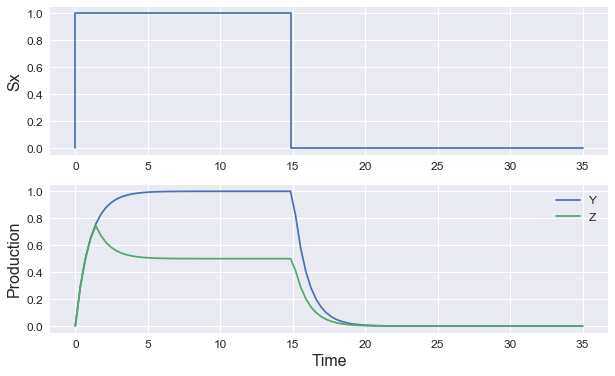

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=False,figsize=(10, 6))
ax1.step(time,signal)
ax1.set_ylabel('Sx')
ax2.plot(time,U2[:,1],label='Y')
ax2.plot(time,U2[:,2],label='Z')
ax2.set_xlabel('Time')
ax2.set_ylabel('Production')
ax2.legend()
plt.show()